# 01-29 Relationships & Similarity



## Introduction

So far, we spent explored how to **summarize single variables** in our datasets using measures of *central tendency*: the mean, median, mode, and measure of *spread*: variance, standard deviation, standard error (standard deviation of a *sampling distribution*).

When we have a column of numbers – say, students' test scores or reaction times from an experiment – we can *compress* that information into a meaningful summary: the mean tells us about the typical value, the variance describes spread, the median gives us the middle value, etc. These are all ways of **aggregating** - *thoughtfully throwing away information to gain insight* - one of the **4 fundamental concepts** we learned about (aggregation, learning, sampling, & uncertainty). 

But this approach misses something crucial – it doesn't tell us anything about how the variables **change together**.  

How might we come up with a *new statistic* that summarize this change?

## Thinking About Similarity

Consider a real-world example that many of you have first hand experience with 😅: 

How would we **summarize the relationship** between the number of *hours* you spend working on an assignment, and the *score* you receive on an assignment?

Just as we can compress a one column of numbers into a single meaningful value (like the mean), perhaps we can *compress the relationship* between these two variables in a way that tells us how "similar" their patterns are.

This notion of **summarizing similarity** is foundational to many of the concepts we'll learn later in this course.

Let's think about what it means for 2 variables to be "similar."

If *hours* and *score* are **similar** then we should be able to express that in a number that reflects how the "move together:" do students who study *more* tend to score *higher*?

Let's play with some data to make this concrete - we'll load a data with observations from 100 students measuring study habits and performance. These data contain a column called `study_time` for the number of hours students prepared and `test_score` for the score they received on their exam:


In [1]:
# Import a helper function we provide to generate some data
from helpers import generate_student_data

# This function returns a polars DataFrame
df = generate_student_data()
df

student,study_time,test_score
str,f64,f64
"""A""",23.820262,100.0
"""B""",17.000786,80.523981
"""C""",19.89369,87.08253
"""D""",26.204466,100.0
"""E""",24.33779,96.944346
…,…,…
"""RRRR""",18.532866,95.350268
"""SSSS""",15.0525,97.822906
"""TTTT""",23.929352,100.0


Let's create a scatter plot of the relationship we want to *summarize*:

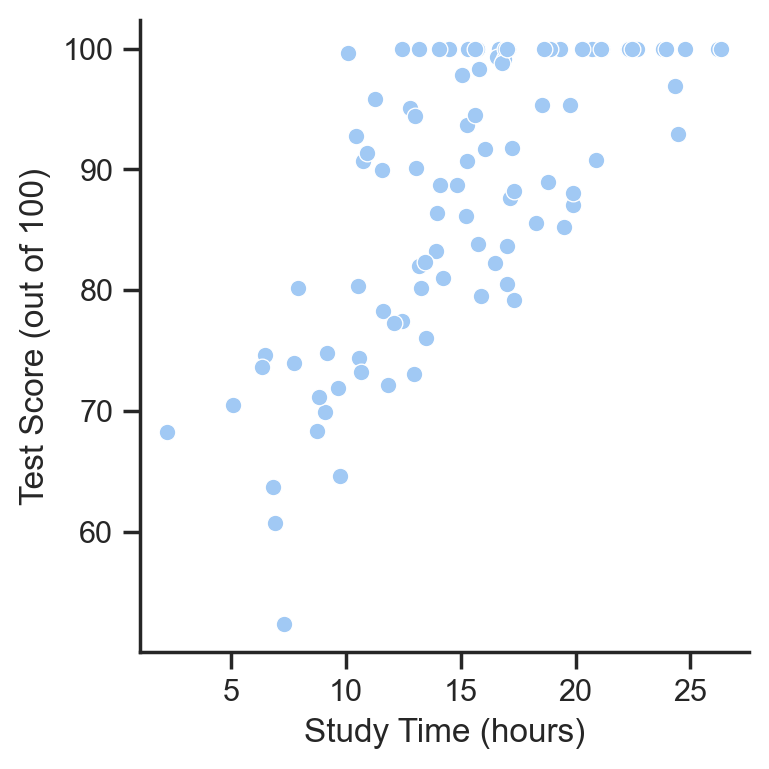

In [2]:
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', palette='pastel')

grid = sns.relplot(
    data=df,
    kind="scatter",
    x="study_time",
    y="test_score",
    height=4,
)

grid.set_axis_labels('Study Time (hours)', 'Test Score (out of 100)')

This looks it might be approximately *linear* - as values on the x-axis (study time) *increases*, so do values on the y-axis (test scores).

## A First Attempt: Dot Products

So our goal is to come up with a single number that captures how well `study_time` and `test_score` *move together*.

One way to capture this "moving together" mathematically is **simply through multiplication**. When two numbers have the same sign (both positive or both negative), their product is positive. When they have opposite signs, their product is negative. This suggests a simple approach: multiply corresponding values and add up the products. In statistics and linear algebra, this is called the **dot product**:

$$
\text{dot\ product}(x, y) = \sum_{i=1}^n x_i y_i
$$

Let's try this out in Python - fortunately this is just a common operation that we can use the `np.dot` function from NumPy to do this for us:

In [3]:
import numpy as np

# Break out the variables into numpy array to work with them directly
study_time = df['study_time'].to_numpy()
test_score = df['test_score'].to_numpy()

dot_product = np.dot(study_time, test_score)

print(f"Dot product: {dot_product:.3f}")

Dot product: 139478.581


### The Problem of Measurement Scale

However, our simple dot product has a problem: it's sensitive to *scale of the data* - in other words the *units* that each variable is measure in. If we measured study time in hours versus minutes, or test scores in percentages versus raw points, our dot product would change drastically. 

You can see this by adjusting the score and time multipliers in the widget below - they control the *units* of each variable by multiplying them by a constant value. Notice how the scatter plots don't move, but the *axis limits* and *dot product* do.

The dot product is also senstive to the *amount* of data we have - since we're just multiplying raw values and adding them up - just increasing the sample size will increase the dot product!

In [4]:
from helpers import dot_widget

dot_widget();

interactive(children=(IntSlider(value=100, description='Sample size', max=500, min=50, step=10), FloatSlider(v…

We could *average* the products of the two variables instead of *summing* them. This is referred to the **mean inner product** in linear algebra. 

$$ \text{mean\ inner\ product}(x, y) = \frac{1}{n}\sum_{i=1}^n x_i y_i $$


In [5]:
mean_inner_product = np.dot(study_time, test_score) / len(study_time)

# OR 

mean_inner_product = np.mean(study_time * test_score)


print(f"Average Inner (dot) Product: {mean_inner_product:.3f}")

Average Inner (dot) Product: 1394.786



It makes the dot product a bit less sensitive to the number of observations: - notice how increasing the sample size just increase the magnitude of the dot product as dramatically as it did before.

However, it's still sensitive to the scale of the variables!

In [6]:
from helpers import dot_avg_widget

dot_avg_widget();

interactive(children=(IntSlider(value=100, description='Sample size', max=500, min=50, step=10), FloatSlider(v…

## A Second Attempt: Co-variance

The short-coming of the average inner/dot product as a measurement of *similarity* is that we can't tell the difference between whether the summary we get back is due to the scale of our measurements or some *underlying relationship* between them - simply changing the scale of our data changes the "scale" of our summary.

Instead, we might hone-in on a more *specific* measure of similarity: how much these variables move together *with respect to their typical values* - in other words - **how similar are the spreads of these variables**?

We already know about a measure of spread for a single variable - it's *variance* - the average squared difference between each data-point and its mean.

$$ var(x) = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2 $$

What if we generalized this idea? We could first **center** each variable around it's mean, and *then* compute the average inner product. 

This is known as **co-variance**: it improves the dot product by summarizing *how similarily variables deviate from their means together*


$$ \text{cov}(x,y) = \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) $$

Let's calculate it manually:

In [7]:
study_time_centered = study_time - study_time.mean()
test_score_centered = test_score - test_score.mean()

covariance = np.mean(study_time_centered * test_score_centered)

print(f"Covariance: {covariance}")

Covariance: 41.368349718712906


Numpy also provides a `np.cov` function that returns a **covariance matrix** - where each row/column represents a single variable - in this case our matrix is 2x2 because we have 2 variables: study time and test score.

This matrix contains the *variance* of each variable along the *diagonals* and the *covariance* between each pair of variables along the *off-diagonals*

In [8]:
# Off diagonals are the same calculation!
# Diagnals are variances of each variable
np.cov(study_time, test_score, ddof=0)

array([[ 25.39566548,  41.36834972],
       [ 41.36834972, 133.55365192]])

We can verify this quickly:

In [9]:
study_time_variance = np.var(study_time, ddof=0)
test_score_variance = np.var(test_score, ddof=0)

print(f"Study time variance: {study_time_variance}")
print(f"Test score variance: {test_score_variance}")

Study time variance: 25.395665480373285
Test score variance: 133.5536519193348


Covariance improves on the raw dot product by measuring how variables deviate from their means together. This value will be far from zero when individual data points deviate by similar amounts from their respective means; if they are deviant in the same direction then the covariance is *positive*, whereas if they are deviant in opposite directions the covariance is *negative*.

**Visually** you can think about co-variance as the average dot-product, when we *move* the data to the *origin* of the plot - indicated by the dashed black lines below.

But notice: it *still depends on the scale of our variables*. You can see when you increase the scales, covariance changes because the means of each variable change and therefore their *dispersion* increases.

In [10]:
from helpers import cov_widget

cov_widget();

interactive(children=(IntSlider(value=100, description='Sample size', max=500, min=50, step=10), FloatSlider(v…

## A Third Attempt: Cosine Similarity

One way we can make our summary statistic **invariant** to the scale of the data is to convert our measurement units, i.e. "hours" and "score" into a common "unitless" measure before we multiply them. A very common choice is to use a unit that reflects "distance from the origin". In linear algebra, we call this the **magnitude** or **norm** of a vector - how far the data is spread away from the value `0`.

This looks a lot like the formula for *variance*, but we're not looking at the "spread" around the *mean*, but "total distance" from the value 0.

$$
norm(x) = \sqrt{\sum_{i=1}^n x_i^2}
$$

If we calculate this for both variables and divide the dot product by this value, we get a measure of **cosine similarity**




$$
\cos(x,y) = \frac{dot\ product(x,y)}{norm(x) \times norm(y)} = \frac{\sum_{i=1}^n x_i y_i}{\sqrt{\sum_{i=1}^n x_i^2} \sqrt{\sum_{i=1}^n y_i^2}}
$$

In [11]:
study_norm = np.sqrt(np.sum([student**2 for student in study_time]))   
test_norm = np.sqrt(np.sum([student**2 for student in test_score]))

print(f"Study time norm: {study_norm}")
print(f"Test score norm: {test_norm}")

print(f"Cosine similarity: {np.dot(study_time, test_score) / (study_norm * test_norm)}")

Study time norm: 161.07647027998854
Test score norm: 892.1586038893493
Cosine similarity: 0.9705844944670725


We can check our work using a function from the `scipy` library that returns a cosine *distance*. We just need to substract this from 1 to convert it to a similarity:

In [12]:
from scipy.spatial.distance import cosine

scipy_cos = 1 - cosine(study_time, test_score)
print(f"Scipy Cosine Similarity: {scipy_cos:}")

Scipy Cosine Similarity: 0.9705844944670723


This step of normalizing our dot-product makes our new measure **scale invariant**. Notice how changing the scale of each variable does **not** change the calculation of the cosine similarity. 

In [13]:
from helpers import cos_widget

cos_widget();

interactive(children=(IntSlider(value=100, description='Sample size', max=500, min=50, step=10), FloatSlider(v…

While cosine similarity isn't that popular in basic descriptive statistics it plays an important role when we start building models. You might notice that the way we're calculating a **norm** of each variable includes a "sum-of-squares" operation. In fact this particular type of "norm" is called a **Euclidean norm** or **L2 norm** - because it's fundamentally calculating a value that's akin to the **squared distance** between data points.

However, there's still one issue with this summary statistic...

We've achieved *scale invariance* by assuming that 0 is a meaingful reference point for both variables, but our real question concerns how similar variables are **with respect to their typical values**

## A Final Attempt: Correlation


### Making Variables Comparable: Z-Scores

This is where z-scores come in: when we convert a value to a z-score, we're *normalizing* the data **with respect to its mean**. 

$$ x_{z} = \frac{x - \bar{x}}{\sigma} $$

Because the denominator here contains standard deviation, which depends upon the *mean* of a variable, we're converting our variable into units that reflect "standardized distance from the mean"

What we're really doing is profound – we have a scale that we can translate *any variable* into the *same* units.  

A z-score of +1 always means one standard deviation above the mean, regardless of whether we're talking about hours, percentages, or milliseconds. When we z-score our variables, we're not just changing their units; we're making them "speak the same language" while preserving their relative patterns.


In [14]:
from scipy.stats import zscore

test_score_z = (test_score - test_score.mean())/ test_score.std()

#OR
study_time_z = zscore(study_time)

Let's visualize the effect of z-scoring:

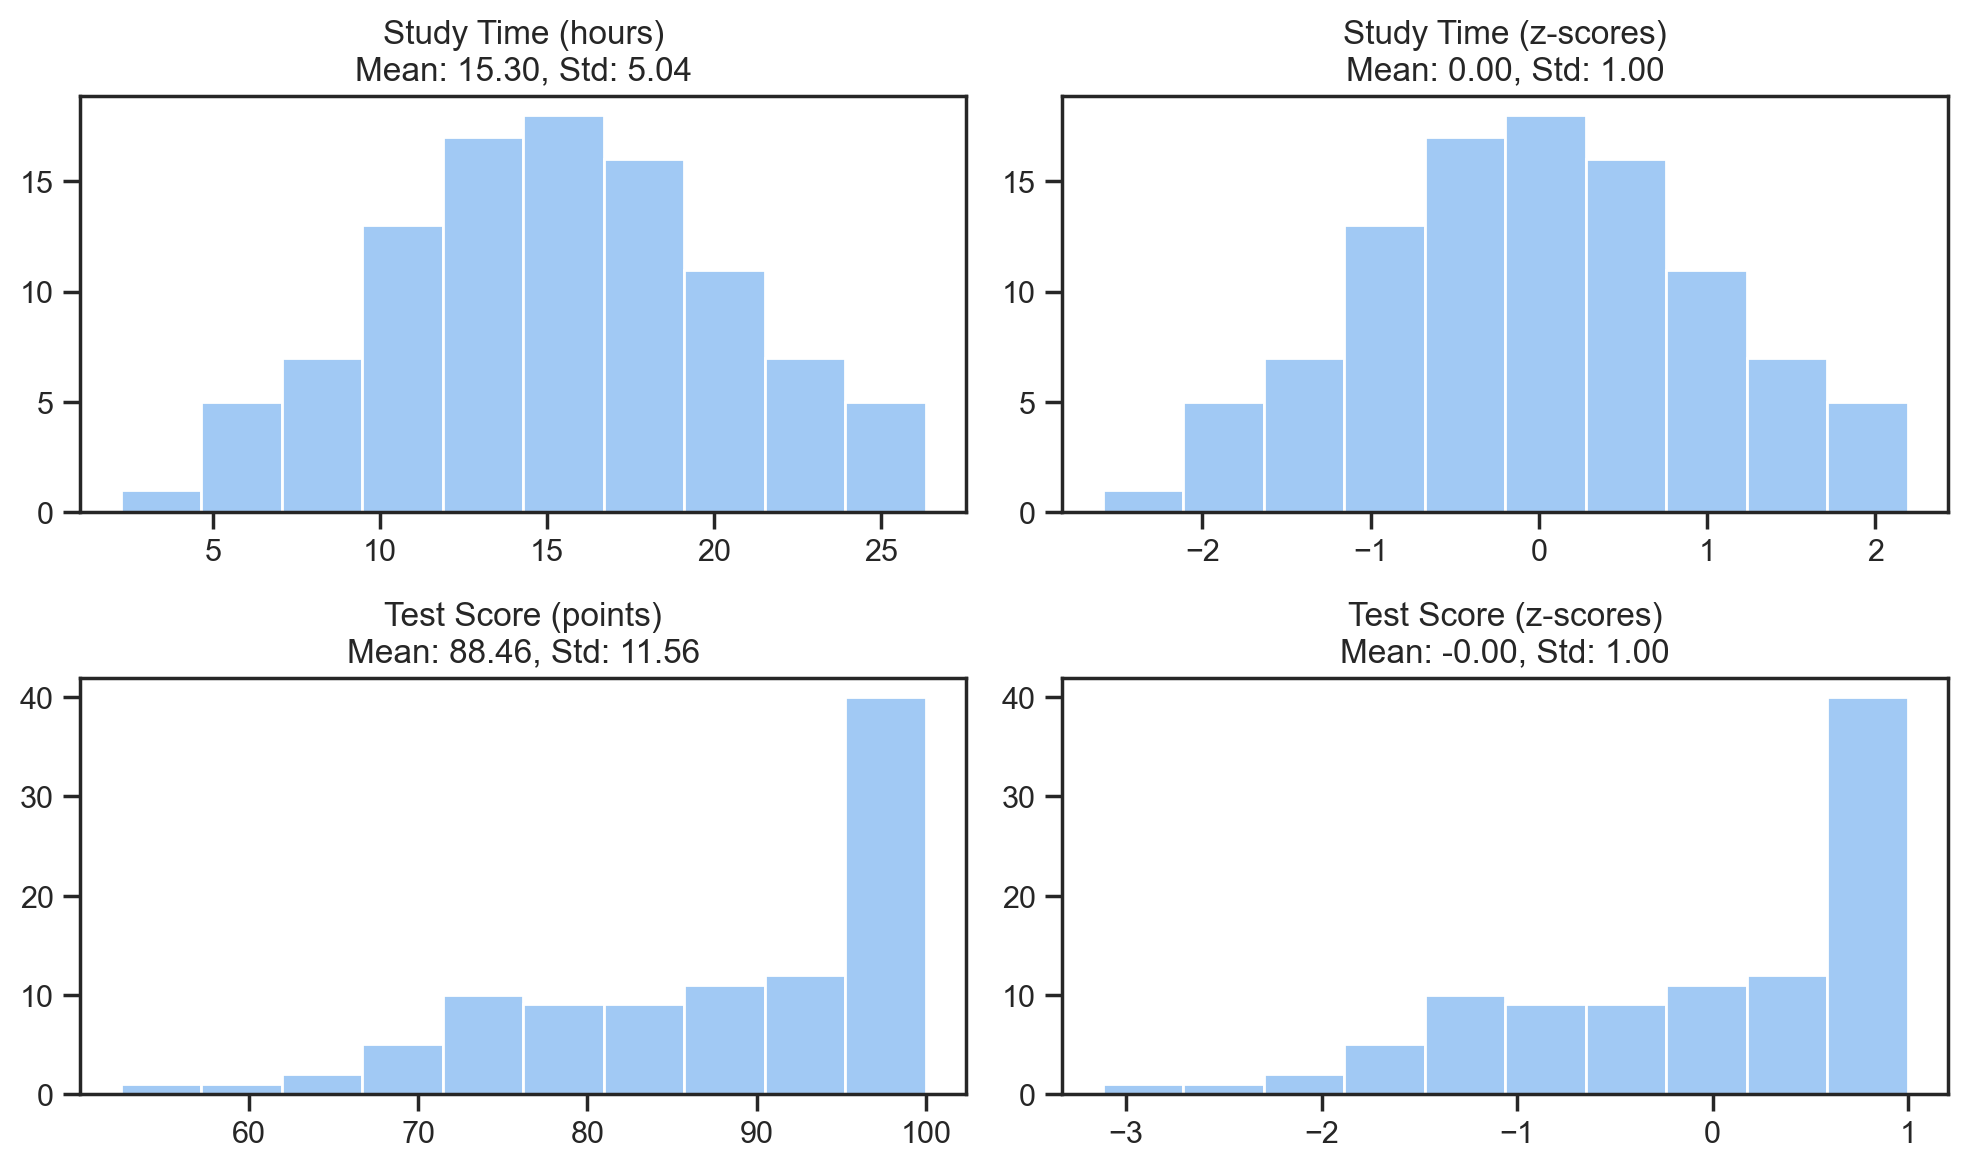

In [15]:
f, ax = plt.subplots(2, 2, figsize=(10,6));
ax[0,0].hist(study_time);
ax[0,0].set_title(f'Study Time (hours)\nMean: {study_time.mean():.2f}, Std: {study_time.std():.2f}');
ax[0,1].hist(study_time_z);
ax[0,1].set_title(f'Study Time (z-scores)\nMean: {study_time_z.mean():.2f}, Std: {study_time_z.std():.2f}');

ax[1,0].hist(test_score);
ax[1,0].set_title(f'Test Score (points)\nMean: {test_score.mean():.2f}, Std: {test_score.std():.2f}');
ax[1,1].hist(test_score_z);
ax[1,1].set_title(f'Test Score (z-scores)\nMean: {test_score_z.mean():.2f}, Std: {test_score_z.std():.2f}');
plt.tight_layout();

Notice how we're not changing the *shape* of the data - just re-scaling it to a different range of standardized units:



### Correlation: The Dot Product of Z-Scores

And here's where everything comes together - what if we used a *summary statistic* that was simply the product of z-scores?

This would combine the best properties of dot products - *higher* values means *more* similar - while accounting for different units of measurement - everything is in "distance from mean" units.

In fact, this is **exactly** what Pearson correlation is: the **average dot product of z-scores**! 

$$ r_{x,y} = \frac{1}{n-1} \sum_{i=1}^n z_{x_i} z_{y_i} $$

We can also see this through the lens of *co-variance*:  

If co-variance is equivalent to the *centered* average dot-product of two variables - correlation is just **normalizing covariance** using the product of both variables' standard deviations.

$$ r_{x,y} = \frac{\text{cov}(x,y)}{\sigma_x \sigma_y} $$

Or written out more completely:

$$
correlation(x,y) = \frac{\sum_{i=1}^n (a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^n (a_i - \bar{a})^2} \sqrt{\sum_{i=1}^n (b_i - \bar{b})^2}}
$$



In [16]:
from helpers import corr_widget

corr_widget();

interactive(children=(IntSlider(value=100, description='Sample size', max=500, min=50, step=10), FloatSlider(v…

## Wrapping Up

### Key Takeaways

Building up this notion of a **summary statistic that captures similarity** by-hand should give you a bit more of an intuition for some key properties of correlation:

1. *Centering* data makes our metric **more interpretable with respect to the central tendency** of each variable  

2. *Normalizing* data makes our metric **scale invariant**  

3. Using *z-scores* (standardized distance from the mean) as our normalization factor, **guarantees our metric is always between -1 and 1**

4. Using a *dot-product* means we can only capture approximately **linear relationships**


Now that you can see how measures like correlation *summarize relationships* between variables, it should be abundantly clear that **correlation measures association, not causation** - it's a mathematical *necessity* that follows from how correlation is constructed.

Nothing we've calculated above takes into account which variable *caused* the other -  correlation only sees patterns in standardized deviations; it has no way to know whether X causes Y, Y causes X, or if both are caused by some third variable Z. When we find a correlation of some value `r` **all we know** is that their z-scores tend to move together.

To go into additional depth on your own here are some additional resources:

- [Cheatsheet comparing these measures](https://eshinjolly.com/2018/04/12/similarity_metrics/)
- [Chap 13 - Modeling continuous relationships](https://statsthinking21.github.io/statsthinking21-core-site/modeling-continuous-relationships.html#covariance-and-correlation)
- [Nice visual animation of co-variance](https://www.youtube.com/watch?v=TPcAnExkWwQ)
- [Longer walkthrough video of co-variance](https://www.youtube.com/watch?v=qtaqvPAeEJYf)

### Other Measures of Association

We've seen how correlation emerged from a simple idea (dot products) refined through centering and scaling. But correlation isn't always the best tool for the job. Here are some other measures you're likely to encounter, each capturing different aspects of relationships:

**Spearman Correlation**
Instead of using raw values, Spearman correlation works with *ranks*. It's calculated exactly like Pearson correlation, but after converting values to their rank order. This makes it:
- More robust to outliers
- Able to capture *monotonic* relationships (consistently increasing/decreasing, even if not linear)
- Useful when you care about order but not magnitude

**Euclidean Distance** The straight-line distance between points  
- Intuitive for spatial data
- Sensitive to scale (like the raw dot product)
- Used in many clustering algorithms

**Manhattan Distance** Sum of absolute differences  
- More robust to outliers than Euclidean
- Natural for grid-like spaces (like city blocks)
- Often used in high-dimensional data


Remember: There's no "best" measure of association. Each captures different aspects of relationships between variables and provides different approaches for *summarizing* them. Understanding what each measure preserves and discards helps you choose the right tool for your research questions.



### Looking Forward: Regression

Next week we'll dive into *linear models* and regression, which builds naturally from correlation. 

The key connection we'll explore in more depth is:

$$ β = r \frac{σ_Y}{σ_X} $$

which states that the *slope* of a "line-of-best-fit" is equivalent to correlation *scaled* by the ratio of standard deviations between variables. 

And critically, if we z-score our variables *first*, then correlation and simple regression are equivalent! β == r


### For Next Time (also on course website)

Please try to find some time to watch the following videos before next week. We won't cover them in depth but will build upon these ideas as we move forward

- [The Essence of Linear Algebra](https://www.3blue1brown.com/topics/linear-algebra) by 3blue1brown. These are bite-sized videos to give you some *high level* intuitions about linear algebra basics, with particularly lovely visuals. If you never formally took any linear algebra (like Eshin), feel math-phobic, or simply need a refresher - this series offers a fresh and fun perspective on about the mathematics that underlies most of the modeling you're likely to do. You don't have watch the full series (unless you want to!), but please check out the following chapters:  
  - [Chap 1: Vectors, what even ar they?](https://www.3blue1brown.com/lessons/vectors) *~10m*
  - [Chap 2: Linear combinations, span, and basis vectors](https://www.3blue1brown.com/lessons/span) *~10m*
  - [Chap 3: Linear transformations and matrices](https://www.3blue1brown.com/lessons/linear-transformations) ~*11m*
  - [Chap 4: Matrix multiplication as composition](https://www.3blue1brown.com/lessons/matrix-multiplication) ~*10m*
  - [Chap 5: Three-dimensional linear transformations](https://www.3blue1brown.com/lessons/3d-transformations) ~*5m*
  - [Chap 7: Inverse matrices, column space, and null space](https://www.3blue1brown.com/lessons/inverse-matrices) ~*12m*


## Challenge exercises - Your Turn

Just as the some summary statistics of *central tendency* like the *mean* can hide important features of a distribution (like bimodality or skewness), correlation can hide important features of *relationships*.

A correlation of 0 doesn't mean there's no relationship - it just means there's no detectable *linear* relationship: a perfect U-shaped relationship could have a correlation of zero!

At the same time a correlation of 1/-1 doen't mean there's a perfectly linear relationshps: we need to *visualize* the underlying data.

Here's a classic example we saw in a previous lab: Anscombe's quartet

<img src="./figs/quartet.png" width="50%" alt="Figure 1">


In the next cell we've loaded this dataset for you. Use it to create some figures and answer the following questions:

In [17]:
anscombe = pl.DataFrame(sns.load_dataset("anscombe"))
anscombe.head()

dataset,x,y
str,f64,f64
"""I""",10.0,8.04
"""I""",8.0,6.95
"""I""",13.0,7.58
"""I""",9.0,8.81
"""I""",11.0,8.33


1. Add 2 new columns that reflect: mean-centered and z-scored versions of x and y **separately** per dataset

2. Create 3 scatterplot grids using `sns.relplot` to visualize the relationship between x & y, their centered version, and their z-scored versions separately per dataset. Does anything change? Why or why not?

3. Create 2 new columns that reflect: ranked version of x and y **separately** per dataset

*Hint: you can use `col('x').rank()` in [polars](https://docs.pola.rs/api/python/stable/reference/series/api/polars.Series.rank.html) to get the rank of a column*

4. Create two scatterplot grids this time using `sns.lmplot`. Have one plot the original (non-rank transformed) data with a line-of-best-fit and the other plot the rank-transformed data with a line-of-best fit. Do they look the same? Why or why not?

5. Inspecting the raw-data scatterplots for datasets 3 and 4 - there look like there might be one "outlier" in each dataset. Use `.filter` in Polars to remove each one and create 3 *new* scatterplots using `sns.relplot` visualizing the relationship between x & y, their centered versions, and their z-scored version. Did anything change? Why or why not?

*Hint: Remember to re-calculate centered and z-scored versions of x and y after filtering!*
